<a href="https://colab.research.google.com/github/techYamasaki/topic_model/blob/master/topicmodel_with_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDAでトピックモデルを構築する
"save_livedoor_corpus.jpynb"にてlivedoorコーパスのダウンロード、形態素解析、ストップワード除去等の下準備済み

In [ ]:
!pip install sudachipy
!pip install pyLDAvis
!pip install SudachiPy
!pip install https://object-storage.tyo2.conoha.io/v1/nc_2520839e1f9641b08211a5c85243124a/sudachi/SudachiDict_core-20190927.tar.gz

In [ ]:
from gensim import corpora, models
from os import listdir, path
from sudachipy import tokenizer, dictionary
from collections import Counter
from wordcloud import WordCloud
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
f = open('corpus.pkl','rb')
saved_docs = pickle.load(f)

In [ ]:
#学習用と評価用に分ける
docs = saved_docs[:]
docs2 = []
sw_count = 0
dt_count = 0
s_count = 0
me_count = 0
ilh_count = 0
kc_count = 0
p_count = 0
tn_count = 0
lh_count = 0
for doc in saved_docs:
  if doc["tag"] == "sports-watch" and sw_count < 900/3:
    docs2.append(doc)
    docs.remove(doc)
    sw_count += 1
  elif doc["tag"] == "dokujo-tsushin" and dt_count < 870/3:
    docs2.append(doc)
    docs.remove(doc)
    dt_count += 1
  elif doc["tag"] == "smax" and s_count < 870/3:
    docs2.append(doc)
    docs.remove(doc)
    s_count += 1
  elif doc["tag"] == "movie-enter" and me_count < 870/3:
    docs2.append(doc)
    docs.remove(doc)
    me_count += 1
  elif doc["tag"] == "it-life-hack" and ilh_count < 870/3:
    docs2.append(doc)
    docs.remove(doc)
    ilh_count += 1
  elif doc["tag"] == "kaden-channel" and kc_count < 864/3:
    docs2.append(doc)
    docs.remove(doc)
    kc_count += 1
  elif doc["tag"] == "peachy" and p_count < 842/3:
    docs2.append(doc)
    docs.remove(doc)
    p_count += 1
  elif doc["tag"] == "topic-news" and tn_count < 770/3:
    docs2.append(doc)
    docs.remove(doc)
    tn_count += 1
  elif doc["tag"] == "livedoor-homme" and lh_count < 511/3:
    docs2.append(doc)
    docs.remove(doc)
    lh_count += 1

In [ ]:
#　全文書の数の確認
saved_tag_list = []
for doc in saved_docs:
    saved_tag_list.append(doc["tag"])
    
saved_df = pd.DataFrame(saved_tag_list)
saved_tag_counts = saved_df[0].value_counts()
saved_tag_counts

sports-watch      900
it-life-hack      870
movie-enter       870
smax              870
dokujo-tsushin    870
kaden-channel     864
peachy            842
topic-news        770
livedoor-homme    511
Name: 0, dtype: int64

In [ ]:
# 学習用文書の数の確認
tag_list = []
for doc in docs:
    tag_list.append(doc["tag"])
    
df = pd.DataFrame(tag_list)
tag_counts = df[0].value_counts()
tag_counts

sports-watch      600
dokujo-tsushin    580
it-life-hack      580
movie-enter       580
smax              580
kaden-channel     576
peachy            561
topic-news        513
livedoor-homme    340
Name: 0, dtype: int64

In [ ]:
# 評価用文書の数の確認
tag_list2 = []
for doc in docs2:
    tag_list2.append(doc["tag"])
    
df2 = pd.DataFrame(tag_list2)
tag_counts2 = df2[0].value_counts()
tag_counts2

sports-watch      300
dokujo-tsushin    290
it-life-hack      290
movie-enter       290
smax              290
kaden-channel     288
peachy            281
topic-news        257
livedoor-homme    171
Name: 0, dtype: int64

In [ ]:
# docs(学習用)の走査の順番を確認(dateframe通り)
tag = ""
for i in tag_list:
    if i != tag :
        print(i)
        tag = i

peachy
sports-watch
dokujo-tsushin
movie-enter
smax
kaden-channel
topic-news
it-life-hack
livedoor-homme


In [ ]:
#学習用の文書をリスト化
text_list = []

for item in docs:
    text_list.append(item["token"]) 

## bag-of-wards作成

In [ ]:
#学習用bow作成
dictionary =corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=2,no_above=0.2)
#学習用bowを辞書番号でベクトル化
corpus=[dictionary.doc2bow(tokens) for tokens in text_list]

## トピックモデル構築

In [ ]:
#LDAトピック数の設定
num_topics=9

#LDAモデルの学習
model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=5)
model.save('lda.model')

## 学習用全文書のトピック分布を取得

In [ ]:
prob_doc = np.array(model.get_document_topics(corpus, minimum_probability=0))[:,:,1]

# DataFrameに収納
L=[ z for z in range(1,num_topics+1)]
col_name = list(map(lambda x: "Prob_"+str(x),L))
df_prob = pd.DataFrame(prob_doc)
df_prob.columns = col_name


def del_Prob(x):
    return int(x.split("_")[1])

df_prob["Max"] = df_prob.idxmax(axis=1)
df_prob["Max"] = df_prob["Max"].apply(lambda x : del_Prob(x))

## 記事のジャンルごとのトピック分布取得

In [ ]:
#tag_countsを正しく更新
tag_counts = [561, 600, 580, 580, 580, 576, 513, 580, 340]
tag_counts

[561, 600, 580, 580, 580, 576, 513, 580, 340]

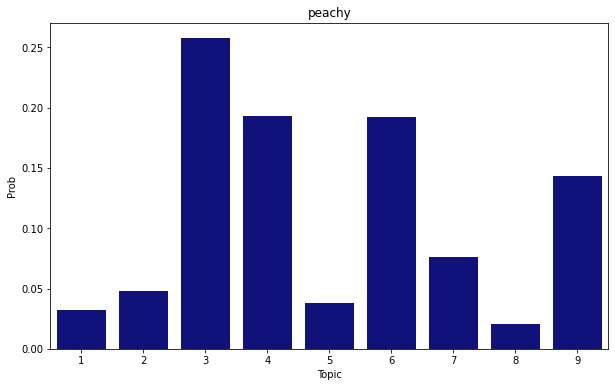

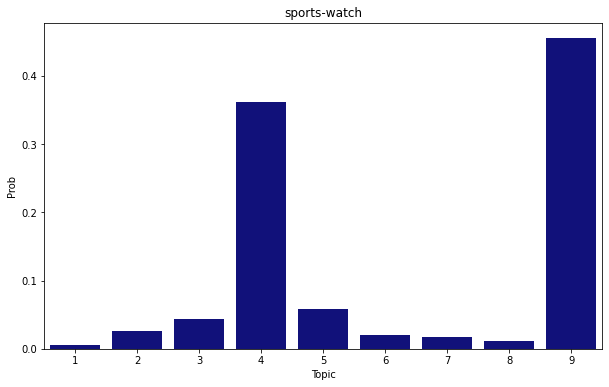

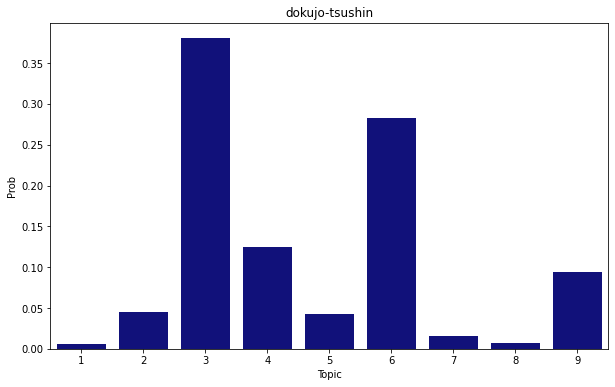

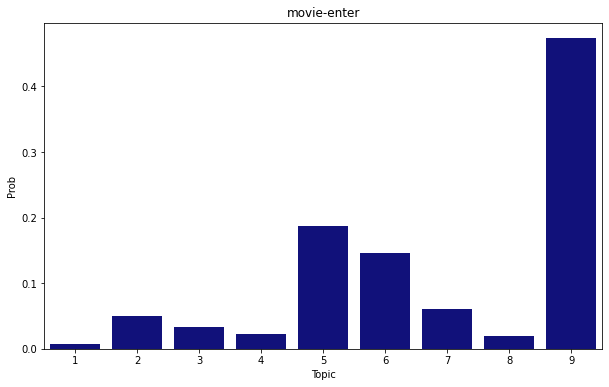

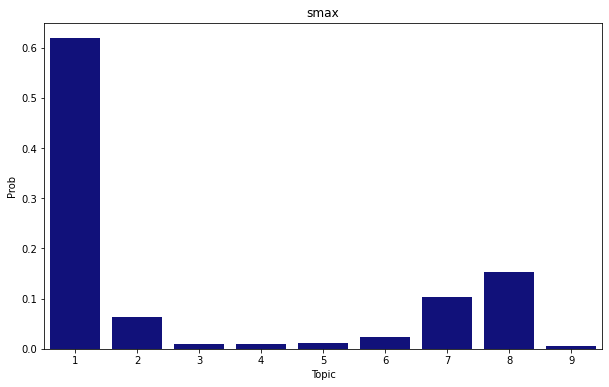

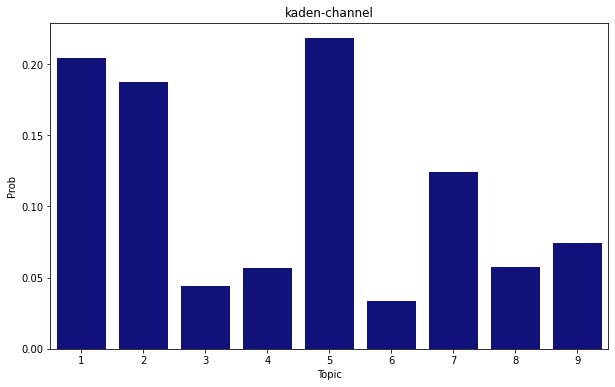

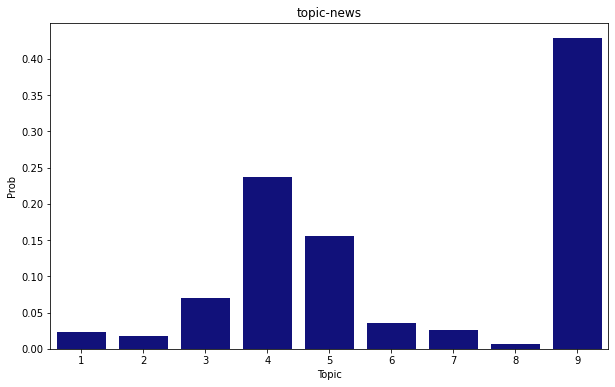

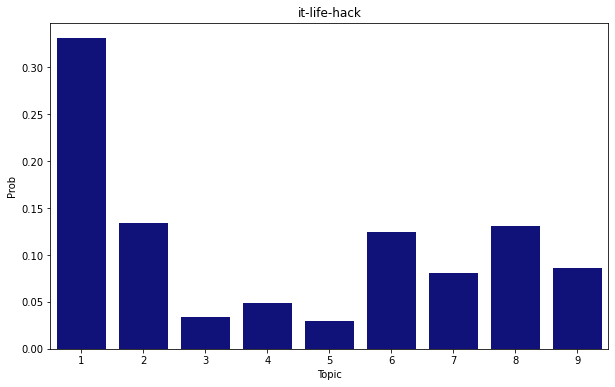

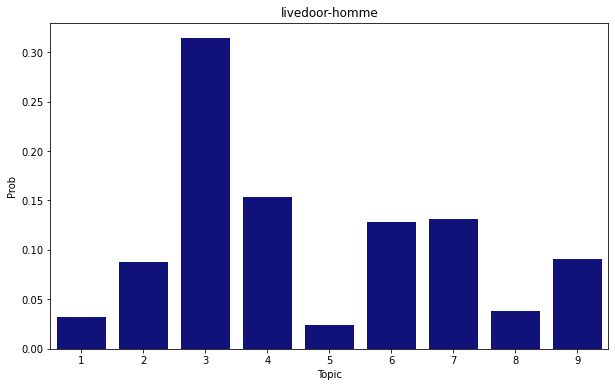

In [ ]:
start = 0

for count in tag_counts:
    
    df_topic = pd.DataFrame(df_prob[start:start+count].drop("Max",axis=1).sum()/df_prob[start:start+count].drop("Max",axis=1).sum().sum())
    df_topic.columns = ["Prob"]
    df_topic["Topic"] = [ z for z in range(1,num_topics+1)]    

    plt.figure(figsize = (10,6))
    ax = sns.barplot(x="Topic",y="Prob",data=df_topic,color="darkblue")
    ax.set_xlabel("Topic",fontsize=10)
    ax.set_ylabel("Prob",fontsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    plt.title(tag_list[start])
    plt.show()

    start += count

## pyLDAvisでトピックの意味可視化(PCoA, MMDS, t-SNE)

In [ ]:
vis_pcoa = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)

# save as html
pyLDAvis.display(vis_pcoa)

## coherence, perplexityを確認して、トピック数選定

In [ ]:
from gensim.models.ldamodel import CoherenceModel

array = []
for i in range(1, 31):

    lda = models.LdaModel(corpus = corpus, id2word = dictionary, num_topics =i, random_state = 5)

    cm = CoherenceModel(model = lda, corpus = corpus, coherence = 'u_mass')
    coherence = cm.get_coherence()

    perwordbound = lda.log_perplexity(corpus)
    perplexity = np.exp2(-perwordbound)
    
    array.append([i, coherence, perplexity])
    
    print(f"num_topics = {i}, coherence = {coherence}, perplexity = {perplexity}")

Text(0.5, 0, 'num_topics')

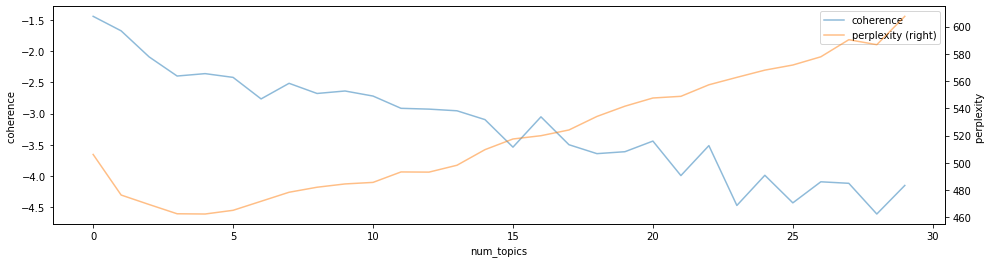

In [ ]:
evaluation = pd.DataFrame(array)
evaluation_ =  evaluation[[1, 2]]
evaluation_.columns = ["coherence", "perplexity"]

ax = evaluation_.plot(secondary_y=["perplexity"], figsize=(16,4), alpha=0.5, legend=True)
ax.set_ylabel('coherence ', fontsize=10)
ax.right_ax.set_ylabel('perplexity ', fontsize=10)
ax.set_xlabel('num_topics', fontsize=10)

## 対象記事群のbag-of-wards作成

In [ ]:
#評価用の文書をリスト化
text_list_evaluation = []

for item in docs2:
    text_list_evaluation.append(item["token"]) 

In [ ]:
#評価用bow作成
dictionary_evaluation =corpora.Dictionary(text_list_evaluation)
dictionary_evaluation.filter_extremes(no_below=2,no_above=0.2)
#評価用bowを辞書番号でベクトル化
corpus_evaluation=[dictionary_evaluation.doc2bow(tokens) for tokens in text_list_evaluation]

## 構築したトピックモデルで対象記事の全文書のトピック分布取得

In [ ]:
prob_doc_evaluation = np.array(model.get_document_topics(corpus_evaluation, minimum_probability=0))[:,:,1]

# DataFrameに収納
L=[ z for z in range(1,num_topics+1)]
col_name = list(map(lambda x: "Prob_"+str(x),L))
df_prob_evaluation = pd.DataFrame(prob_doc_evaluation)
df_prob_evaluation.columns = col_name


def del_Prob(x):
    return int(x.split("_")[1])

df_prob_evaluation["Max"] = df_prob_evaluation.idxmax(axis=1)
df_prob_evaluation["Max"] = df_prob_evaluation["Max"].apply(lambda x : del_Prob(x))

In [ ]:
df_prob_evaluation

,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9,Max
0,0.000431,0.040790,0.817148,0.053855,0.000431,0.000431,0.086052,0.000431,0.000431,3
1,0.000682,0.000682,0.888027,0.000682,0.000682,0.080841,0.027039,0.000682,0.000682,3
2,0.005417,0.105933,0.636622,0.001069,0.001069,0.246683,0.001069,0.001069,0.001069,3
3,0.030825,0.000632,0.262795,0.010233,0.000632,0.223860,0.000632,0.000632,0.469761,9
4,0.045052,0.000708,0.064303,0.557004,0.000708,0.077693,0.000708,0.000708,0.253116,4
...,...,...,...,...,...,...,...,...,...,...
2452,0.052172,0.083330,0.207653,0.084319,0.043012,0.089368,0.246881,0.000517,0.192749,7
2453,0.011476,0.035340,0.214161,0.220526,0.034873,0.128699,0.100163,0.022829,0.231933,9
2454,0.000253,0.035027,0.279798,0.164305,0.000253,0.231488,0.037285,0.000253,0.251336,3
2455,0.001049,0.001049,0.238624,0.187617,0.308268,0.001049,0.001049,0.001049,0.260248,5


In [ ]:
topic_evaluation_df = pd.concat([df2, df_prob_evaluation], axis=1)

In [ ]:
topic_evaluation_df

,tag,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9,Max
0,peachy,0.000431,0.040790,0.817148,0.053855,0.000431,0.000431,0.086052,0.000431,0.000431,3
1,peachy,0.000682,0.000682,0.888027,0.000682,0.000682,0.080841,0.027039,0.000682,0.000682,3
2,peachy,0.005417,0.105933,0.636622,0.001069,0.001069,0.246683,0.001069,0.001069,0.001069,3
3,peachy,0.030825,0.000632,0.262795,0.010233,0.000632,0.223860,0.000632,0.000632,0.469761,9
4,peachy,0.045052,0.000708,0.064303,0.557004,0.000708,0.077693,0.000708,0.000708,0.253116,4
...,...,...,...,...,...,...,...,...,...,...,...
2452,livedoor-homme,0.052172,0.083330,0.207653,0.084319,0.043012,0.089368,0.246881,0.000517,0.192749,7
2453,livedoor-homme,0.011476,0.035340,0.214161,0.220526,0.034873,0.128699,0.100163,0.022829,0.231933,9
2454,livedoor-homme,0.000253,0.035027,0.279798,0.164305,0.000253,0.231488,0.037285,0.000253,0.251336,3
2455,livedoor-homme,0.001049,0.001049,0.238624,0.187617,0.308268,0.001049,0.001049,0.001049,0.260248,5


In [ ]:
with open('topic_evaluation_df.pkl', 'wb') as temp:
  pickle.dump(topic_evaluation_df, temp)

# 対象記事のトピック分布へPCA適用

In [ ]:
f2 = open('topic_evaluation_df.pkl','rb')
topic_evaluation_df = pickle.load(f2)

In [ ]:
topic_evaluation_df

,tag,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9,Max
0,peachy,0.000431,0.040790,0.817148,0.053855,0.000431,0.000431,0.086052,0.000431,0.000431,3
1,peachy,0.000682,0.000682,0.888027,0.000682,0.000682,0.080841,0.027039,0.000682,0.000682,3
2,peachy,0.005417,0.105933,0.636622,0.001069,0.001069,0.246683,0.001069,0.001069,0.001069,3
3,peachy,0.030825,0.000632,0.262795,0.010233,0.000632,0.223860,0.000632,0.000632,0.469761,9
4,peachy,0.045052,0.000708,0.064303,0.557004,0.000708,0.077693,0.000708,0.000708,0.253116,4
...,...,...,...,...,...,...,...,...,...,...,...
2452,livedoor-homme,0.052172,0.083330,0.207653,0.084319,0.043012,0.089368,0.246881,0.000517,0.192749,7
2453,livedoor-homme,0.011476,0.035340,0.214161,0.220526,0.034873,0.128699,0.100163,0.022829,0.231933,9
2454,livedoor-homme,0.000253,0.035027,0.279798,0.164305,0.000253,0.231488,0.037285,0.000253,0.251336,3
2455,livedoor-homme,0.001049,0.001049,0.238624,0.187617,0.308268,0.001049,0.001049,0.001049,0.260248,5


In [ ]:
tag_id = [["peachy", 1], ["sports-watch", 2], ["dokujo-tsushin", 3], ["movie-enter", 4], ["smax", 5], ["kaden-channel", 6], ["topic-news", 7], ["it-life-hack", 8], ["livedoor-homme", 9]]

In [ ]:
for i, j in tag_id:
  topic_evaluation_df = topic_evaluation_df.replace(i, j)

In [ ]:
topic_evaluation_df

,tag,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9,Max
0,1,0.000431,0.040790,0.817148,0.053855,0.000431,0.000431,0.086052,0.000431,0.000431,3
1,1,0.000682,0.000682,0.888027,0.000682,0.000682,0.080841,0.027039,0.000682,0.000682,3
2,1,0.005417,0.105933,0.636622,0.001069,0.001069,0.246683,0.001069,0.001069,0.001069,3
3,1,0.030825,0.000632,0.262795,0.010233,0.000632,0.223860,0.000632,0.000632,0.469761,9
4,1,0.045052,0.000708,0.064303,0.557004,0.000708,0.077693,0.000708,0.000708,0.253116,4
...,...,...,...,...,...,...,...,...,...,...,...
2452,9,0.052172,0.083330,0.207653,0.084319,0.043012,0.089368,0.246881,0.000517,0.192749,7
2453,9,0.011476,0.035340,0.214161,0.220526,0.034873,0.128699,0.100163,0.022829,0.231933,9
2454,9,0.000253,0.035027,0.279798,0.164305,0.000253,0.231488,0.037285,0.000253,0.251336,3
2455,9,0.001049,0.001049,0.238624,0.187617,0.308268,0.001049,0.001049,0.001049,0.260248,5


In [ ]:
# 図やグラフを図示するためのライブラリをインポートする。
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn #機械学習のライブラリ
from sklearn.decomposition import PCA #主成分分析器

In [ ]:
# 行列の標準化
topic_evaluation_dfs = topic_evaluation_df.iloc[:, 1:10].apply(lambda x: (x-x.mean())/x.std(), axis=0)
topic_evaluation_dfs.head()

,Prob_1,Prob_2,Prob_3,Prob_4,Prob_5,Prob_6,Prob_7,Prob_8,Prob_9
0,-0.525158,-0.255346,5.069709,-1.519867,-0.761213,-1.544646,0.370380,-0.584691,-1.738665
1,-0.518293,-0.862235,5.672389,-1.996141,-0.757155,-0.790392,-0.481739,-0.577498,-1.736290
2,-0.388829,0.730360,3.534727,-1.992675,-0.750905,0.765217,-0.856728,-0.566416,-1.732633
3,0.305881,-0.862997,0.356124,-1.910595,-0.757970,0.551137,-0.863044,-0.578939,2.698387
4,0.694902,-0.861840,-1.331616,2.986856,-0.756736,-0.819924,-0.861942,-0.576756,0.650219


In [ ]:
pca = PCA()
pca.fit(topic_evaluation_dfs)
# データを主成分空間に写像
feature = pca.transform(topic_evaluation_dfs)

In [ ]:
# 主成分得点
pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(topic_evaluation_dfs.columns))]).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,5.154489,-1.328363,-1.750747,-0.008508,0.254263,-0.936601,1.102413,-1.124561,5.221994e-08
1,5.477994,-1.731133,-1.210326,0.360535,-0.437598,-0.712558,1.668691,-1.966485,-2.480609e-07
2,3.162103,-2.028070,-0.756148,-0.652613,-1.871065,-0.941602,1.278469,-1.106478,5.660713e-08
3,1.094315,1.158491,2.287477,-1.040750,-0.873103,1.772399,0.526781,-0.904745,-1.368739e-07
4,-2.002000,1.767942,-1.700667,1.036951,0.617046,1.679639,-0.204018,-0.564586,9.093213e-08


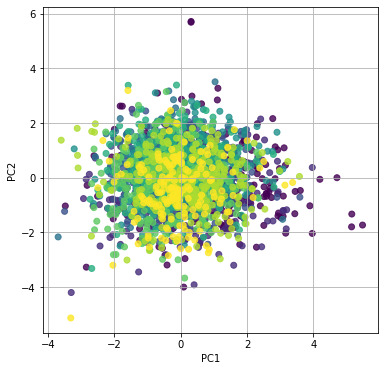

In [ ]:
# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=list(topic_evaluation_df.iloc[:, 0]))
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()